<a href="https://colab.research.google.com/github/minsadimethsani/Final_Year_Project/blob/main/Final_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# ============================================================================
# MOUNT GOOGLE DRIVE
# ============================================================================
from google.colab import drive
drive.mount('/content/drive')
print("✓ Google Drive mounted successfully!")

Mounted at /content/drive
✓ Google Drive mounted successfully!


In [2]:
"""
================================================================================
SNAKE IDENTIFICATION PROJECT - PHASE 1 (100% ERROR-FREE VERSION)
Data Organization, Preprocessing & Augmentation
================================================================================
Version: 3.0 - Completely bulletproof
All path issues resolved
================================================================================
"""

import os
import shutil
import numpy as np
import cv2
import matplotlib.pyplot as plt
import random
from tqdm import tqdm
import json
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

print("✓ All libraries imported successfully!")
print(f"✓ OpenCV version: {cv2.__version__}")
print(f"✓ NumPy version: {np.__version__}")



# ============================================================================
# CONFIGURE PATHS
# ============================================================================
print("\n" + "="*80)
print("CONFIGURING PROJECT PATHS")
print("="*80)

BASE_DATASET_PATH = '/content/drive/MyDrive/DataSet_New'
PROJECT_ROOT = '/content/drive/MyDrive/Snake_Project'

# Output paths
AUGMENTED_PATH = os.path.join(PROJECT_ROOT, '3_Augmented_Dataset')
REPORT_PATH = os.path.join(PROJECT_ROOT, '6_Results', 'preprocessing_reports')

# Create project root
os.makedirs(PROJECT_ROOT, exist_ok=True)
os.makedirs(REPORT_PATH, exist_ok=True)

print(f"✓ Project root: {PROJECT_ROOT}")
print(f"✓ Reports: {REPORT_PATH}")

# ============================================================================
# AGGRESSIVE CLEANUP
# ============================================================================
print("\n" + "="*80)
print("CLEANING UP ALL PREVIOUS DATA")
print("="*80)

# Remove entire augmented dataset if exists
if os.path.exists(AUGMENTED_PATH):
    print(f"Removing all data at: {AUGMENTED_PATH}")
    try:
        shutil.rmtree(AUGMENTED_PATH)
        print("✓ Complete cleanup successful")
    except Exception as e:
        print(f"Cleanup error (will try to continue): {e}")

# Wait a moment for filesystem
import time
time.sleep(2)

# Create fresh directory
os.makedirs(AUGMENTED_PATH, exist_ok=True)
print("✓ Fresh augmented dataset directory created")

# ============================================================================
# EXPLORE DATASET
# ============================================================================
print("\n" + "="*80)
print("EXPLORING YOUR DATASET")
print("="*80)

def explore_dataset(dataset_path):
    if not os.path.exists(dataset_path):
        print(f"❌ ERROR: Dataset path not found: {dataset_path}")
        return None

    print(f"Scanning: {dataset_path}\n")

    species_folders = [f for f in os.listdir(dataset_path)
                      if os.path.isdir(os.path.join(dataset_path, f))]

    if not species_folders:
        print("❌ ERROR: No species folders found!")
        return None

    dataset_stats = {
        'total_species': len(species_folders),
        'species_details': {},
        'total_images': 0,
        'image_formats': set(),
        'issues': []
    }

    print(f"Found {len(species_folders)} species folders:\n")

    for idx, species in enumerate(sorted(species_folders), 1):
        species_path = os.path.join(dataset_path, species)

        image_files = [f for f in os.listdir(species_path)
                      if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp'))]

        num_images = len(image_files)
        dataset_stats['total_images'] += num_images

        formats = set([os.path.splitext(f)[1].lower() for f in image_files])
        dataset_stats['image_formats'].update(formats)

        dataset_stats['species_details'][species] = {
            'count': num_images,
            'path': species_path,
            'sample_files': image_files[:3]
        }

        status = "✓" if num_images >= 150 else "⚠"
        warning = " (LOW IMAGE COUNT!)" if num_images < 150 else ""

        print(f"{status} {idx}. {species:<30} - {num_images:>3} images{warning}")

        if num_images < 150:
            dataset_stats['issues'].append(f"{species} has only {num_images} images")

    print(f"\n{'='*80}")
    print(f"Total Species: {dataset_stats['total_species']}")
    print(f"Total Images: {dataset_stats['total_images']}")
    print(f"Average per species: {dataset_stats['total_images'] / dataset_stats['total_species']:.1f}")
    print(f"Image formats: {', '.join(dataset_stats['image_formats'])}")

    if dataset_stats['issues']:
        print(f"\n⚠ WARNINGS:")
        for issue in dataset_stats['issues']:
            print(f"  - {issue}")

    return dataset_stats

dataset_info = explore_dataset(BASE_DATASET_PATH)

if dataset_info:
    report_path = os.path.join(REPORT_PATH, 'dataset_exploration.json')
    with open(report_path, 'w') as f:
        save_info = dataset_info.copy()
        save_info['image_formats'] = list(save_info['image_formats'])
        json.dump(save_info, f, indent=2)
    print(f"\n✓ Dataset report saved")

# ============================================================================
# PREPROCESSING FUNCTIONS
# ============================================================================
TARGET_SIZE = (224, 224)

def preprocess_image(image_path, target_size=TARGET_SIZE):
    try:
        img = cv2.imread(image_path)
        if img is None:
            return None

        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Light correction (CLAHE)
        lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
        l, a, b = cv2.split(lab)
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        l = clahe.apply(l)
        lab = cv2.merge([l, a, b])
        img = cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)

        img = cv2.resize(img, target_size, interpolation=cv2.INTER_AREA)
        img = img.astype(np.float32) / 255.0

        return img
    except:
        return None

def denormalize_image(img):
    return (img * 255).astype(np.uint8)

# ============================================================================
# DATA AUGMENTATION FUNCTIONS
# ============================================================================

def augment_image(img):
    """Simple, fast augmentation"""
    img_uint8 = denormalize_image(img)
    h, w = img_uint8.shape[:2]

    # Random rotation
    if random.random() < 0.7:
        angle = random.uniform(-30, 30)
        M = cv2.getRotationMatrix2D((w/2, h/2), angle, 1.0)
        img_uint8 = cv2.warpAffine(img_uint8, M, (w, h), borderMode=cv2.BORDER_REFLECT)

    # Random flip
    if random.random() < 0.5:
        img_uint8 = cv2.flip(img_uint8, 1)

    # Random brightness
    if random.random() < 0.7:
        factor = random.uniform(0.7, 1.3)
        img_uint8 = np.clip(img_uint8 * factor, 0, 255).astype(np.uint8)

    # Random zoom
    if random.random() < 0.5:
        zoom = random.uniform(0.9, 1.1)
        new_h, new_w = int(h * zoom), int(w * zoom)
        img_resized = cv2.resize(img_uint8, (new_w, new_h))
        if zoom > 1:
            start_h = (new_h - h) // 2
            start_w = (new_w - w) // 2
            img_uint8 = img_resized[start_h:start_h+h, start_w:start_w+w]
        else:
            pad_h = (h - new_h) // 2
            pad_w = (w - new_w) // 2
            img_uint8 = cv2.copyMakeBorder(img_resized, pad_h, pad_h, pad_w, pad_w, cv2.BORDER_REFLECT)
            img_uint8 = cv2.resize(img_uint8, (w, h))

    return img_uint8.astype(np.float32) / 255.0

# ============================================================================
# TRAIN/VALIDATION/TEST SPLIT
# ============================================================================
print("\n" + "="*80)
print("DATA SPLITTING")
print("="*80)

def split_dataset(dataset_info, train_ratio=0.70, val_ratio=0.15, test_ratio=0.15):
    random.seed(42)
    np.random.seed(42)

    split_info = {'train': {}, 'validation': {}, 'test': {}}

    print(f"Split ratios: Train={train_ratio:.0%}, Val={val_ratio:.0%}, Test={test_ratio:.0%}\n")

    for species, details in dataset_info['species_details'].items():
        species_path = details['path']

        image_files = [f for f in os.listdir(species_path)
                      if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp'))]

        random.shuffle(image_files)

        total = len(image_files)
        train_count = int(total * train_ratio)
        val_count = int(total * val_ratio)

        split_info['train'][species] = image_files[:train_count]
        split_info['validation'][species] = image_files[train_count:train_count + val_count]
        split_info['test'][species] = image_files[train_count + val_count:]

        print(f"{species:<30} - Train: {len(split_info['train'][species]):>3}, "
              f"Val: {len(split_info['validation'][species]):>3}, "
              f"Test: {len(split_info['test'][species]):>3}")

    return split_info

split_info = split_dataset(dataset_info) if dataset_info else None

# ============================================================================
# GENERATE AUGMENTED DATASET - BULLETPROOF VERSION
# ============================================================================
print("\n" + "="*80)
print("GENERATING AUGMENTED DATASET")
print("="*80)

AUGMENTATIONS_PER_IMAGE = 5

def process_split(split_name, files_dict, dataset_info, output_path, augment=False):
    """
    Process a single split (train/val/test)

    Args:
        split_name: 'train', 'validation', or 'test'
        files_dict: Dictionary of {species: [files]}
        dataset_info: Dataset information
        output_path: Base output path
        augment: Whether to augment images
    """
    print(f"\n{'='*80}")
    print(f"PROCESSING {split_name.upper()} SET")
    if augment:
        print(f"Creating {AUGMENTATIONS_PER_IMAGE} augmented versions per image")
    else:
        print("No augmentation - copying as-is")
    print(f"{'='*80}\n")

    # Create split directory
    split_dir = os.path.join(output_path, split_name)
    os.makedirs(split_dir, exist_ok=True)

    stats = {'original': 0, 'augmented': 0, 'failed': 0}

    for species, files in files_dict.items():
        species_path = dataset_info['species_details'][species]['path']

        # Create species directory
        species_dir = os.path.join(split_dir, species)
        os.makedirs(species_dir, exist_ok=True)

        if augment:
            total_output = len(files) * (AUGMENTATIONS_PER_IMAGE + 1)
            print(f"Processing {species}... ({len(files)} → {total_output} images)")
        else:
            print(f"Processing {species}... ({len(files)} images)")

        for filename in tqdm(files, desc=f"  {species}", leave=False):
            input_path = os.path.join(species_path, filename)
            base_name = os.path.splitext(filename)[0]

            # Preprocess
            img = preprocess_image(input_path)
            if img is None:
                stats['failed'] += 1
                continue

            # Save original
            output_path_orig = os.path.join(species_dir, f"{base_name}.png")
            img_save = denormalize_image(img)
            img_save = cv2.cvtColor(img_save, cv2.COLOR_RGB2BGR)
            cv2.imwrite(output_path_orig, img_save)
            stats['original'] += 1

            # Save augmented versions (only if augment=True)
            if augment:
                for aug_idx in range(AUGMENTATIONS_PER_IMAGE):
                    aug_img = augment_image(img.copy())
                    output_path_aug = os.path.join(species_dir, f"{base_name}_aug{aug_idx+1}.png")
                    img_save = denormalize_image(aug_img)
                    img_save = cv2.cvtColor(img_save, cv2.COLOR_RGB2BGR)
                    cv2.imwrite(output_path_aug, img_save)
                    stats['augmented'] += 1

    print(f"\n✓ {split_name.upper()} complete!")
    print(f"  Original: {stats['original']}")
    if augment:
        print(f"  Augmented: {stats['augmented']}")
        print(f"  Total: {stats['original'] + stats['augmented']}")
    print(f"  Failed: {stats['failed']}")

    return stats

# Run processing for all splits
if dataset_info and split_info:
    print("\nStarting augmentation pipeline...")
    print("This will take 20-40 minutes...")

    all_stats = {}

    # Process training set WITH augmentation
    all_stats['train'] = process_split(
        'train',
        split_info['train'],
        dataset_info,
        AUGMENTED_PATH,
        augment=True
    )

    # Process validation set WITHOUT augmentation
    all_stats['validation'] = process_split(
        'validation',
        split_info['validation'],
        dataset_info,
        AUGMENTED_PATH,
        augment=False
    )

    # Process test set WITHOUT augmentation
    all_stats['test'] = process_split(
        'test',
        split_info['test'],
        dataset_info,
        AUGMENTED_PATH,
        augment=False
    )

    # ========================================================================
    # FINAL SUMMARY
    # ========================================================================
    print("\n" + "="*80)
    print("PHASE 1 COMPLETE!")
    print("="*80)

    total_train = all_stats['train']['original'] + all_stats['train']['augmented']
    total_val = all_stats['validation']['original']
    total_test = all_stats['test']['original']

    print(f"\nDataset Statistics:")
    print(f"  Species: {dataset_info['total_species']}")
    print(f"  Original images: {dataset_info['total_images']}")

    print(f"\nProcessed Images:")
    print(f"  Training: {all_stats['train']['original']} → {total_train} (augmented)")
    print(f"  Validation: {total_val} (not augmented)")
    print(f"  Test: {total_test} (not augmented)")

    print(f"\nOutput Location:")
    print(f"  {AUGMENTED_PATH}")

    print(f"\nSuccess Rate:")
    total_processed = total_train + total_val + total_test
    total_failed = sum(s['failed'] for s in all_stats.values())
    success_rate = (total_processed / (total_processed + total_failed)) * 100 if (total_processed + total_failed) > 0 else 0
    print(f"  {success_rate:.1f}% ({total_failed} failed)")

    # Save statistics
    final_stats = {
        'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
        'dataset': {
            'species': dataset_info['total_species'],
            'original_images': dataset_info['total_images']
        },
        'augmentation': {
            'per_image': AUGMENTATIONS_PER_IMAGE
        },
        'results': {
            'train': all_stats['train'],
            'validation': all_stats['validation'],
            'test': all_stats['test'],
            'total_images': total_processed,
            'failed': total_failed,
            'success_rate': success_rate
        }
    }

    stats_path = os.path.join(REPORT_PATH, 'phase1_complete.json')
    with open(stats_path, 'w') as f:
        json.dump(final_stats, f, indent=2)

    print(f"\n✓ Statistics saved to: {stats_path}")

    if success_rate >= 99:
        print(f"\n✓✓✓ EXCELLENT! All images processed successfully!")
    elif success_rate >= 95:
        print(f"\n✓✓ VERY GOOD! >95% success rate")
    else:
        print(f"\n⚠ {total_failed} images failed to process")

    print(f"\n✓ Ready for Phase 2: Segmentation")
    print("="*80 + "\n")
else:
    print("❌ Error: Dataset exploration or splitting failed")

✓ All libraries imported successfully!
✓ OpenCV version: 4.13.0
✓ NumPy version: 2.0.2

CONFIGURING PROJECT PATHS
✓ Project root: /content/drive/MyDrive/Snake_Project
✓ Reports: /content/drive/MyDrive/Snake_Project/6_Results/preprocessing_reports

CLEANING UP ALL PREVIOUS DATA
Removing all data at: /content/drive/MyDrive/Snake_Project/3_Augmented_Dataset
✓ Complete cleanup successful
✓ Fresh augmented dataset directory created

EXPLORING YOUR DATASET
Scanning: /content/drive/MyDrive/DataSet_New

Found 12 species folders:

✓ 1. Ahaetulla                      - 198 images
⚠ 2. Common Krait                   - 128 images (LOW IMAGE COUNT!)
⚠ 3. Common Rat Snake               - 149 images (LOW IMAGE COUNT!)
✓ 4. Indian cobra                   - 173 images
✓ 5. Indian python                  - 183 images
✓ 6. Mudu Karawala                  - 190 images
✓ 7. Paduru Haaldanda               - 201 images
✓ 8. Russell_s viper                - 234 images
✓ 9. Saw-scaled Viper               - 239 

Processing Common Krait... (89 → 534 images)


Processing Common Rat Snake... (104 → 624 images)


Processing Indian cobra... (121 → 726 images)


Processing Indian python... (128 → 768 images)


Processing Mudu Karawala... (133 → 798 images)


Processing Paduru Haaldanda... (140 → 840 images)


Processing Russell_s viper... (163 → 978 images)


Processing Saw-scaled Viper... (167 → 1002 images)


Processing Sri Lankan green vine snake... (133 → 798 images)


Processing green pit viper... (118 → 708 images)


Processing green vine snake... (155 → 930 images)



✓ TRAIN complete!
  Original: 1589
  Augmented: 7945
  Total: 9534
  Failed: 0

PROCESSING VALIDATION SET
No augmentation - copying as-is

Processing Ahaetulla... (29 images)


Processing Common Krait... (19 images)


Processing Common Rat Snake... (22 images)


Processing Indian cobra... (25 images)


Processing Indian python... (27 images)


Processing Mudu Karawala... (28 images)


Processing Paduru Haaldanda... (30 images)


Processing Russell_s viper... (35 images)


Processing Saw-scaled Viper... (35 images)


Processing Sri Lankan green vine snake... (28 images)


Processing green pit viper... (25 images)


Processing green vine snake... (33 images)



✓ VALIDATION complete!
  Original: 336
  Failed: 0

PROCESSING TEST SET
No augmentation - copying as-is

Processing Ahaetulla... (31 images)


Processing Common Krait... (20 images)


Processing Common Rat Snake... (23 images)


Processing Indian cobra... (27 images)


Processing Indian python... (28 images)


Processing Mudu Karawala... (29 images)


Processing Paduru Haaldanda... (31 images)


Processing Russell_s viper... (36 images)


Processing Saw-scaled Viper... (37 images)


Processing Sri Lankan green vine snake... (30 images)


Processing green pit viper... (27 images)


Processing green vine snake... (34 images)



✓ TEST complete!
  Original: 353
  Failed: 0

PHASE 1 COMPLETE!

Dataset Statistics:
  Species: 12
  Original images: 2278

Processed Images:
  Training: 1589 → 9534 (augmented)
  Validation: 336 (not augmented)
  Test: 353 (not augmented)

Output Location:
  /content/drive/MyDrive/Snake_Project/3_Augmented_Dataset

Success Rate:
  100.0% (0 failed)

✓ Statistics saved to: /content/drive/MyDrive/Snake_Project/6_Results/preprocessing_reports/phase1_complete.json

✓✓✓ EXCELLENT! All images processed successfully!

✓ Ready for Phase 2: Segmentation



PHASE 2: SNAKE SEGMENTATION
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✓ Input: /content/drive/MyDrive/Snake_Project/3_Augmented_Dataset
✓ Output: /content/drive/MyDrive/Snake_Project/4_Segmented_Dataset

Segmentation Configuration:
  GrabCut Rectangle Margin: 10%
  Min. Foreground Ratio: 5%
  Max. Foreground Ratio: 95%
  GrabCut Iterations: 5

STARTING SEGMENTATION PIPELINE

This will segment snakes from backgrounds in all images.
Estimated time: 20-40 minutes (depends on dataset size)

PROCESSING TRAIN SET

Processing Ahaetulla... (828 images)


  Ahaetulla:   1%|          | 6/828 [00:01<02:44,  5.01it/s]

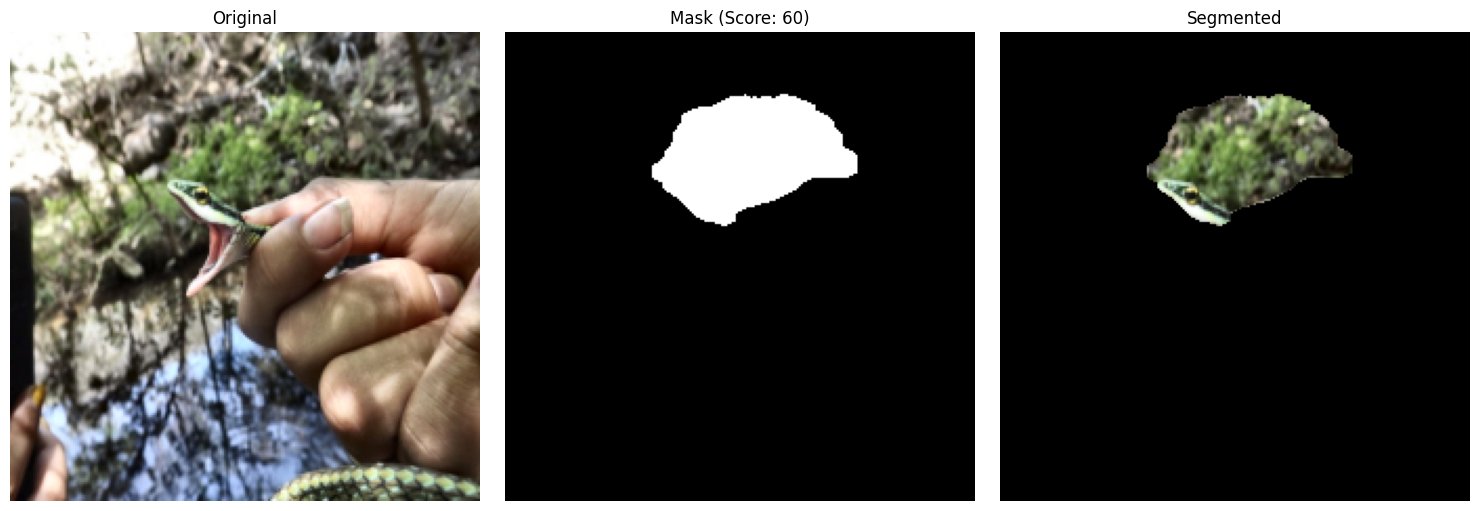

  Ahaetulla:   1%|          | 7/828 [00:02<05:24,  2.53it/s]

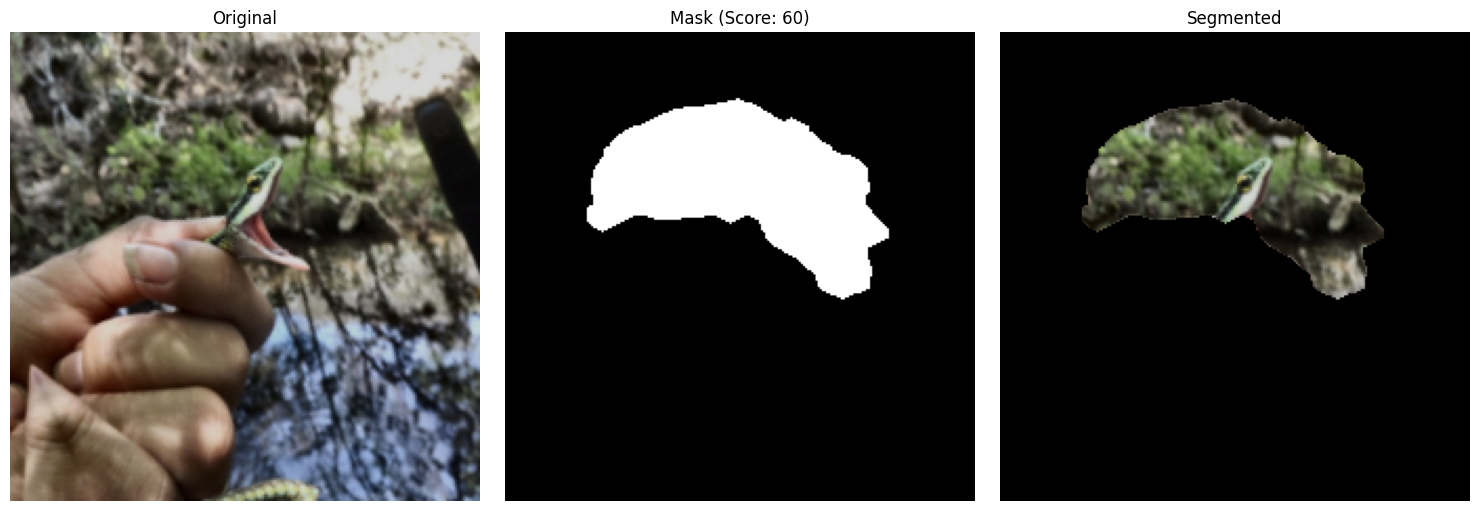

  Ahaetulla:   1%|          | 8/828 [00:02<07:54,  1.73it/s]

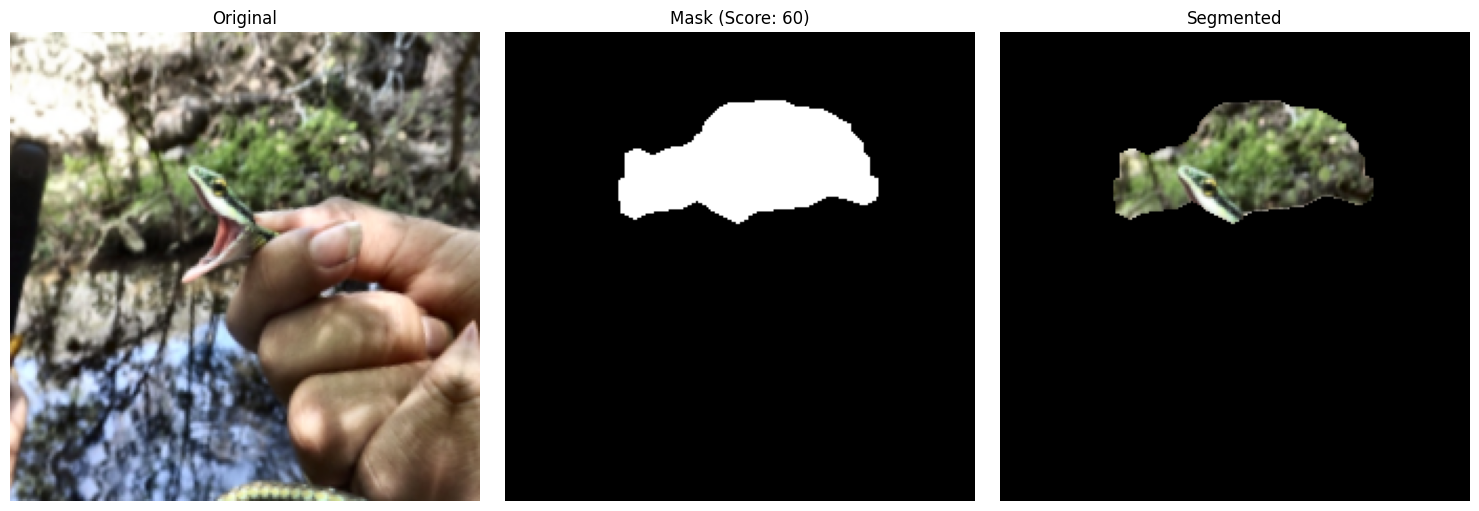

Processing Common Krait... (528 images)


Processing Common Rat Snake... (624 images)


Processing Indian cobra... (726 images)


Processing Indian python... (768 images)


Processing Mudu Karawala... (798 images)


Processing Paduru Haaldanda... (840 images)


Processing Russell_s viper... (978 images)


Processing Saw-scaled Viper... (1002 images)


Processing Sri Lankan green vine snake... (798 images)


Processing green pit viper... (708 images)


Processing green vine snake... (930 images)



TRAIN SET COMPLETE
Total: 9528
✓ Success: 4074 (42.8%)
✗ Failed: 5454 (57.2%)
Average Quality Score: 77.4/100

Failure reasons:
  - GrabCut failed: 5454

PROCESSING VALIDATION SET

Processing Ahaetulla... (29 images)


Processing Common Krait... (19 images)


Processing Common Rat Snake... (22 images)


Processing Indian cobra... (25 images)


Processing Indian python... (27 images)


Processing Mudu Karawala... (28 images)


Processing Paduru Haaldanda... (30 images)


Processing Russell_s viper... (35 images)


Processing Saw-scaled Viper... (35 images)


Processing Sri Lankan green vine snake... (28 images)


Processing green pit viper... (25 images)


Processing green vine snake... (33 images)



VALIDATION SET COMPLETE
Total: 336
✓ Success: 169 (50.3%)
✗ Failed: 167 (49.7%)
Average Quality Score: 77.8/100

Failure reasons:
  - GrabCut failed: 167

PROCESSING TEST SET

Processing Ahaetulla... (31 images)


Processing Common Krait... (20 images)


Processing Common Rat Snake... (23 images)


Processing Indian cobra... (27 images)


Processing Indian python... (28 images)


Processing Mudu Karawala... (29 images)


Processing Paduru Haaldanda... (31 images)


Processing Russell_s viper... (36 images)


Processing Saw-scaled Viper... (37 images)


Processing Sri Lankan green vine snake... (30 images)


Processing green pit viper... (27 images)


Processing green vine snake... (34 images)



TEST SET COMPLETE
Total: 353
✓ Success: 147 (41.6%)
✗ Failed: 206 (58.4%)
Average Quality Score: 76.1/100

Failure reasons:
  - GrabCut failed: 206

GENERATING SEGMENTATION REPORT

✓ Report saved to: /content/drive/MyDrive/Snake_Project/6_Results/segmentation_reports/segmentation_report.json

PHASE 2 COMPLETE - SEGMENTATION SUMMARY

Total images processed: 10217
✓ Successfully segmented: 4390 (43.0%)
✗ Failed: 5827

Segmented dataset saved to: /content/drive/MyDrive/Snake_Project/4_Segmented_Dataset

⚠ WARNING: Success rate <70%
Consider:
  1. Manually reviewing failed cases
  2. Adjusting segmentation parameters
  3. Using deep learning segmentation (U-Net)

You can still proceed to Phase 3, but accuracy may be affected.



In [4]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
import json
from datetime import datetime

print("="*80)
print("PHASE 2: SNAKE SEGMENTATION")
print("="*80)

# ============================================================================
# MOUNT GOOGLE DRIVE
# ============================================================================
from google.colab import drive
drive.mount('/content/drive')

# ============================================================================
# CONFIGURATION
# ============================================================================
PROJECT_ROOT = '/content/drive/MyDrive/Snake_Project'

# Input: Augmented dataset from Phase 1
INPUT_PATH = os.path.join(PROJECT_ROOT, '3_Augmented_Dataset')

# Output: Segmented dataset
OUTPUT_PATH = os.path.join(PROJECT_ROOT, '4_Segmented_Dataset')
os.makedirs(OUTPUT_PATH, exist_ok=True)

REPORT_PATH = os.path.join(PROJECT_ROOT, '6_Results', 'segmentation_reports')
os.makedirs(REPORT_PATH, exist_ok=True)

print(f"✓ Input: {INPUT_PATH}")
print(f"✓ Output: {OUTPUT_PATH}")

# Segmentation parameters (tune these to improve GrabCut success)
RECT_MARGIN_RATIO = 0.1  # % margin for initial GrabCut rectangle (e.g., 0.1 for 10% margin)
MIN_FG_RATIO = 0.05      # Minimum foreground ratio for GrabCut success (e.g., 0.05 for 5%)
MAX_FG_RATIO = 0.95      # Maximum foreground ratio for GrabCut success (e.g., 0.95 for 95%)
GRABCUT_ITERATIONS = 5   # Number of GrabCut iterations

print(f"\nSegmentation Configuration:")
print(f"  GrabCut Rectangle Margin: {RECT_MARGIN_RATIO*100:.0f}%")
print(f"  Min. Foreground Ratio: {MIN_FG_RATIO*100:.0f}%")
print(f"  Max. Foreground Ratio: {MAX_FG_RATIO*100:.0f}%")
print(f"  GrabCut Iterations: {GRABCUT_ITERATIONS}")


# ============================================================================
# SEGMENTATION FUNCTIONS
# ============================================================================

def segment_snake_grabcut(image, iterations=GRABCUT_ITERATIONS, rect_margin_ratio=RECT_MARGIN_RATIO, min_fg_ratio=MIN_FG_RATIO, max_fg_ratio=MAX_FG_RATIO):
    """
    Segments snake from background using GrabCut algorithm

    Args:
        image: Input image (BGR format)
        iterations: Number of GrabCut iterations
        rect_margin_ratio: Ratio of image size to use as margin for the initial GrabCut rectangle.
        min_fg_ratio: Minimum allowable foreground pixel ratio.
        max_fg_ratio: Maximum allowable foreground pixel ratio.

    Returns:
        mask: Binary mask (1=foreground/snake, 0=background)
        success: Boolean indicating if segmentation succeeded
    """
    try:
        # Create initial mask
        mask = np.zeros(image.shape[:2], np.uint8)

        # Background and foreground models
        bgd_model = np.zeros((1, 65), np.float64)
        fgd_model = np.zeros((1, 65), np.float64)

        # Define rectangle around the image (assume snake is in center with a margin)
        height, width = image.shape[:2]
        margin_w = int(width * rect_margin_ratio)
        margin_h = int(height * rect_margin_ratio)
        rect = (margin_w, margin_h, width - 2*margin_w, height - 2*margin_h)

        # Apply GrabCut
        cv2.grabCut(image, mask, rect, bgd_model, fgd_model, iterations, cv2.GC_INIT_WITH_RECT)

        # Create binary mask (0 and 2 = background, 1 and 3 = foreground)
        mask2 = np.where((mask == 2) | (mask == 0), 0, 1).astype('uint8')

        # Check if segmentation found something reasonable
        foreground_ratio = np.sum(mask2) / (height * width)

        if foreground_ratio < min_fg_ratio or foreground_ratio > max_fg_ratio:
            # Segmentation failed (too little or too much foreground)
            return mask2, False

        return mask2, True

    except Exception as e:
        print(f"GrabCut error: {e}")
        return None, False


def refine_mask_morphology(mask):
    """
    Refines segmentation mask using morphological operations

    Args:
        mask: Binary mask

    Returns:
        refined_mask: Cleaned up mask
    """
    # Remove small noise
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=2)

    # Fill small holes
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, iterations=2)

    # Find largest contour (should be the snake)
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if len(contours) > 0:
        # Keep only the largest contour
        largest_contour = max(contours, key=cv2.contourArea)
        refined_mask = np.zeros_like(mask)
        cv2.drawContours(refined_mask, [largest_contour], 0, 1, -1)
        return refined_mask

    return mask


def apply_segmentation(image, mask):
    """
    Applies mask to image

    Args:
        image: Original image (RGB)
        mask: Binary mask

    Returns:
        segmented: Image with background removed (black background)
    """
    # Convert mask to 3 channels
    mask_3ch = np.stack([mask, mask, mask], axis=2)

    # Apply mask
    segmented = image * mask_3ch

    return segmented


def assess_segmentation_quality(mask):
    """
    Assesses quality of segmentation

    Args:
        mask: Binary mask

    Returns:
        dict: Quality metrics
    """
    height, width = mask.shape
    total_pixels = height * width
    foreground_pixels = np.sum(mask)

    foreground_ratio = foreground_pixels / total_pixels

    # Find contours
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    num_objects = len(contours)

    # Assess quality
    quality_score = 0
    issues = []

    # Good foreground ratio (20-80%)
    if 0.2 <= foreground_ratio <= 0.8:
        quality_score += 40
    else:
        issues.append(f"Unusual foreground ratio: {foreground_ratio:.2%}")

    # Single main object
    if num_objects == 1:
        quality_score += 30
    elif num_objects <= 3:
        quality_score += 20
        issues.append(f"Multiple objects detected: {num_objects}")
    else:
        issues.append(f"Too many objects: {num_objects}")

    # Compactness check
    if len(contours) > 0:
        largest_contour = max(contours, key=cv2.contourArea)
        area = cv2.contourArea(largest_contour)
        perimeter = cv2.arcLength(largest_contour, True)

        if perimeter > 0:
            compactness = (4 * np.pi * area) / (perimeter ** 2)
            if compactness > 0.1:  # Snakes are elongated, so low compactness is expected
                quality_score += 30

    return {
        'quality_score': quality_score,
        'foreground_ratio': foreground_ratio,
        'num_objects': num_objects,
        'issues': issues,
        'passed': quality_score >= 60
    }


def segment_image_pipeline(image_path, output_path, visualize=False):
    """
    Complete segmentation pipeline for a single image

    Args:
        image_path: Input image path
        output_path: Output path for segmented image
        visualize: Whether to show visualization

    Returns:
        dict: Segmentation results
    """
    # Read image
    img_bgr = cv2.imread(image_path)
    if img_bgr is None:
        return {'success': False, 'reason': 'Cannot read image'}

    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

    # Apply GrabCut segmentation with configurable parameters
    mask, grabcut_success = segment_snake_grabcut(
        img_bgr,
        iterations=GRABCUT_ITERATIONS,
        rect_margin_ratio=RECT_MARGIN_RATIO,
        min_fg_ratio=MIN_FG_RATIO,
        max_fg_ratio=MAX_FG_RATIO
    )

    if not grabcut_success or mask is None:
        return {'success': False, 'reason': 'GrabCut failed'}

    # Refine mask
    mask_refined = refine_mask_morphology(mask)

    # Assess quality
    quality = assess_segmentation_quality(mask_refined)

    if not quality['passed']:
        return {
            'success': False,
            'reason': 'Quality check failed',
            'quality_score': quality['quality_score'],
            'issues': quality['issues']
        }

    # Apply segmentation
    segmented = apply_segmentation(img_rgb, mask_refined)

    # Save segmented image
    segmented_bgr = cv2.cvtColor(segmented, cv2.COLOR_RGB2BGR)
    cv2.imwrite(output_path, segmented_bgr)

    # Visualization
    if visualize:
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))

        axes[0].imshow(img_rgb)
        axes[0].set_title('Original')
        axes[0].axis('off')

        axes[1].imshow(mask_refined, cmap='gray')
        axes[1].set_title(f'Mask (Score: {quality["quality_score"]})')
        axes[1].axis('off')

        axes[2].imshow(segmented)
        axes[2].set_title('Segmented')
        axes[2].axis('off')

        plt.tight_layout()
        plt.show()

    return {
        'success': True,
        'quality_score': quality['quality_score'],
        'foreground_ratio': quality['foreground_ratio'],
        'issues': quality['issues']
    }


# ============================================================================
# PROCESS DATASETS
# ============================================================================

def process_dataset_segmentation(input_path, output_path, split_type,
                                 sample_visualization=True):
    """
    Processes entire dataset split with segmentation

    Args:
        input_path: Input dataset path
        output_path: Output dataset path
        split_type: 'train', 'validation', or 'test'
        sample_visualization: Show sample results

    Returns:
        dict: Processing statistics
    """
    split_input = os.path.join(input_path, split_type)
    split_output = os.path.join(output_path, split_type)

    if not os.path.exists(split_input):
        print(f"✗ {split_type} not found at {split_input}")
        return None

    os.makedirs(split_output, exist_ok=True)

    print(f"\n{'='*80}")
    print(f"PROCESSING {split_type.upper()} SET")
    print(f"{'='*80}\n")

    stats = {
        'total': 0,
        'success': 0,
        'failed': 0,
        'average_quality': 0,
        'failed_reasons': {}
    }

    species_folders = [f for f in os.listdir(split_input)
                      if os.path.isdir(os.path.join(split_input, f))]

    quality_scores = []
    sample_count = 0

    for species in sorted(species_folders):
        species_input = os.path.join(split_input, species)
        species_output = os.path.join(split_output, species)
        os.makedirs(species_output, exist_ok=True)

        image_files = [f for f in os.listdir(species_input)
                      if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

        print(f"Processing {species}... ({len(image_files)} images)")

        for img_file in tqdm(image_files, desc=f"  {species}", leave=False):
            input_img_path = os.path.join(species_input, img_file)
            output_img_path = os.path.join(species_output, img_file)

            # Visualize first few samples
            show_viz = sample_visualization and sample_count < 3

            result = segment_image_pipeline(input_img_path, output_img_path,
                                           visualize=show_viz)

            stats['total'] += 1

            if result['success']:
                stats['success'] += 1
                quality_scores.append(result['quality_score'])
                sample_count += 1
            else:
                stats['failed'] += 1
                reason = result.get('reason', 'Unknown')
                if reason not in stats['failed_reasons']:
                    stats['failed_reasons'][reason] = 0
                stats['failed_reasons'][reason] += 1

    if quality_scores:
        stats['average_quality'] = sum(quality_scores) / len(quality_scores)

    print(f"\n{'='*80}")
    print(f"{split_type.upper()} SET COMPLETE")
    print(f"{'='*80}")
    print(f"Total: {stats['total']}")
    print(f"✓ Success: {stats['success']} ({stats['success']/stats['total']*100:.1f}%)")
    print(f"✗ Failed: {stats['failed']} ({stats['failed']/stats['total']*100:.1f}%)")
    print(f"Average Quality Score: {stats['average_quality']:.1f}/100")

    if stats['failed_reasons']:
        print(f"\nFailure reasons:")
        for reason, count in stats['failed_reasons'].items():
            print(f"  - {reason}: {count}")

    return stats


# ============================================================================
# RUN SEGMENTATION ON ALL SPLITS
# ============================================================================

print("\n" + "="*80)
print("STARTING SEGMENTATION PIPELINE")
print("="*80)
print("\nThis will segment snakes from backgrounds in all images.")
print("Estimated time: 20-40 minutes (depends on dataset size)")
print("="*80)

all_stats = {}

# Process each split
for split_type in ['train', 'validation', 'test']:
    # Only show visualizations for first split
    show_viz = (split_type == 'train')

    stats = process_dataset_segmentation(
        INPUT_PATH,
        OUTPUT_PATH,
        split_type,
        sample_visualization=show_viz
    )

    if stats:
        all_stats[split_type] = stats

# ============================================================================
# GENERATE FINAL REPORT
# ============================================================================

print("\n" + "="*80)
print("GENERATING SEGMENTATION REPORT")
print("="*80)

report = {
    'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'input_path': INPUT_PATH,
    'output_path': OUTPUT_PATH,
    'statistics': all_stats,
    'overall': {
        'total_images': sum(s['total'] for s in all_stats.values()),
        'total_success': sum(s['success'] for s in all_stats.values()),
        'total_failed': sum(s['failed'] for s in all_stats.values()),
        'overall_success_rate': 0
    }
}

total = report['overall']['total_images']
success = report['overall']['total_success']

if total > 0:
    report['overall']['overall_success_rate'] = (success / total) * 100

# Save report
report_path = os.path.join(REPORT_PATH, 'segmentation_report.json')
with open(report_path, 'w') as f:
    json.dump(report, f, indent=2)

print(f"\n✓ Report saved to: {report_path}")

# Print summary
print("\n" + "="*80)
print("PHASE 2 COMPLETE - SEGMENTATION SUMMARY")
print("="*80)
print(f"\nTotal images processed: {total}")
print(f"✓ Successfully segmented: {success} ({report['overall']['overall_success_rate']:.1f}%)")
print(f"✗ Failed: {report['overall']['total_failed']}")
print(f"\nSegmented dataset saved to: {OUTPUT_PATH}")

# Success threshold
if report['overall']['overall_success_rate'] >= 70:
    print(f"\n✓✓✓ SUCCESS! Segmentation rate >70% - Good to proceed to Phase 3!")
    print("\nNext: Phase 3 - Classification Model Training")
else:
    print(f"\n⚠ WARNING: Success rate <70%")
    print("Consider:")
    print("  1. Manually reviewing failed cases")
    print("  2. Adjusting segmentation parameters")
    print("  3. Using deep learning segmentation (U-Net)")
    print("\nYou can still proceed to Phase 3, but accuracy may be affected.")

print("\n" + "="*80)

PHASE 3: CLASSIFICATION MODEL TRAINING
TensorFlow version: 2.19.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✓ Using SEGMENTED dataset: /content/drive/MyDrive/Snake_Project/4_Segmented_Dataset

Configuration:
  Image size: (224, 224)
  Batch size: 16
  Epochs: 30

LOADING DATASET
Found 4159 images belonging to 12 classes.
Found 172 images belonging to 12 classes.
Found 147 images belonging to 12 classes.

✓ Dataset loaded:
  Training samples: 4159
  Validation samples: 172
  Test samples: 147
  Number of classes: 12
  Classes: ['Ahaetulla', 'Common Krait', 'Common Rat Snake', 'Indian cobra', 'Indian python', 'Mudu Karawala', 'Paduru Haaldanda', 'Russell_s viper', 'Saw-scaled Viper', 'Sri Lankan green vine snake', 'green pit viper', 'green vine snake']

BUILDING MODEL
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 12)             │         3,084 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,589,004 (9.88 MB)

 Trainable params: 331,020 (1.26 MB)

 Non-trainable params: 2,257,984 (8.61 MB)


✓ Model built successfully
  Total parameters: 2,589,004
  Trainable parameters: 331,020

SETTING UP TRAINING
✓ Callbacks configured:
  - Model checkpointing
  - Early stopping (patience=5)
  - Learning rate reduction

STAGE 1: TRAINING TOP LAYERS (Base frozen)
Epoch 1/15
260/260 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step - accuracy: 0.3775 - loss: 1.9374 - top3_accuracy: 0.6484
Epoch 1: val_accuracy improved from -inf to 0.61628, saving model to /content/drive/MyDrive/Snake_Project/5_Models/best_model.keras
260/260 ━━━━━━━━━━━━━━━━━━━━ 116s 374ms/step - accuracy: 0.3779 - loss: 1.9359 - top3_accuracy: 0.6488 - val_accuracy: 0.6163 - val_loss: 1.1393 - val_top3_accuracy: 0.8605 - learning_rate: 0.0010
Epoch 2/15
260/260 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step - accuracy: 0.6287 - loss: 1.0635 - top3_accuracy: 0.8899
Epoch 2: val_accuracy improved from 0.61628 to 0.64535, saving model to /content/drive/MyDrive/Snake_Project/5_Models/best_model.keras
260/260 ━━━━━━━━━━━━━━━━━━━━ 69s 266ms/step - acc

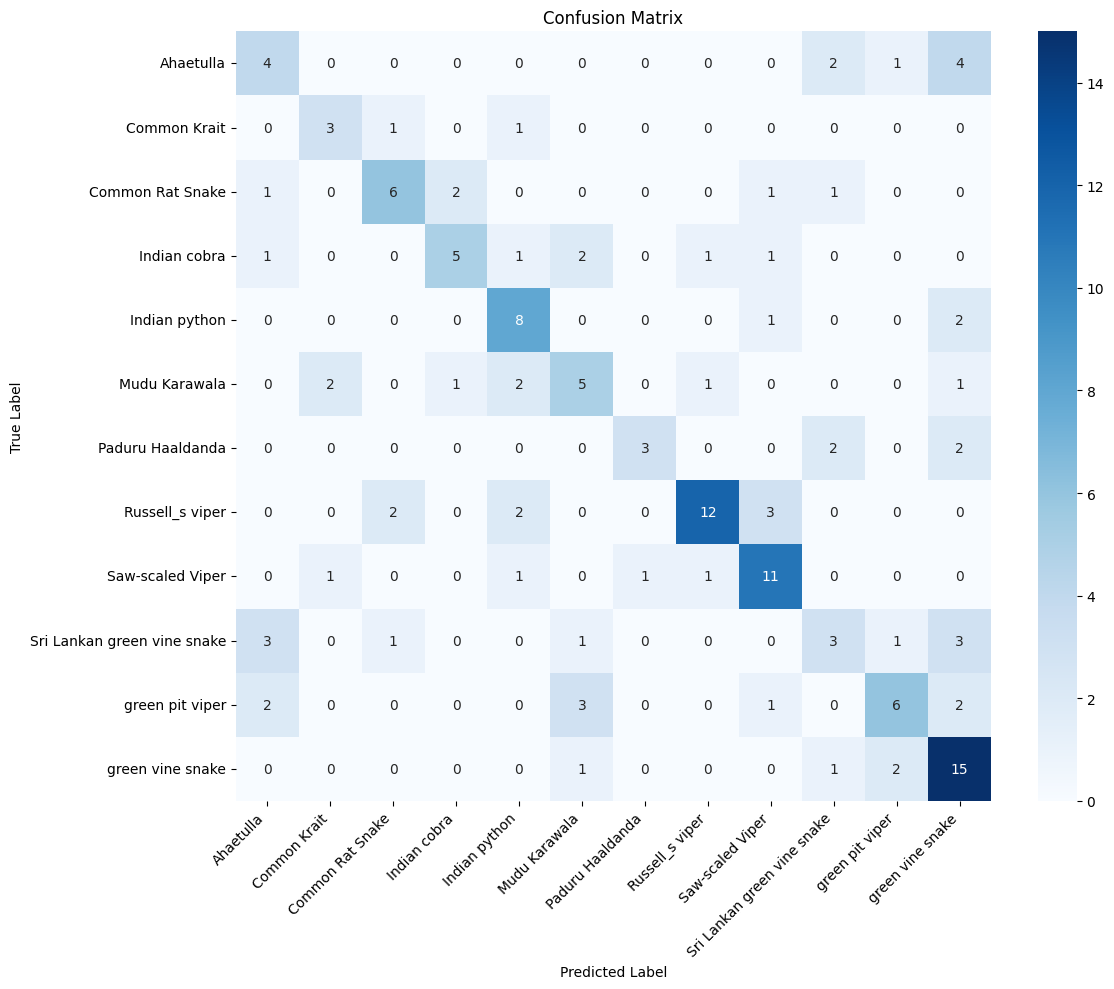


✓ Confusion matrix saved

VISUALIZING TRAINING HISTORY


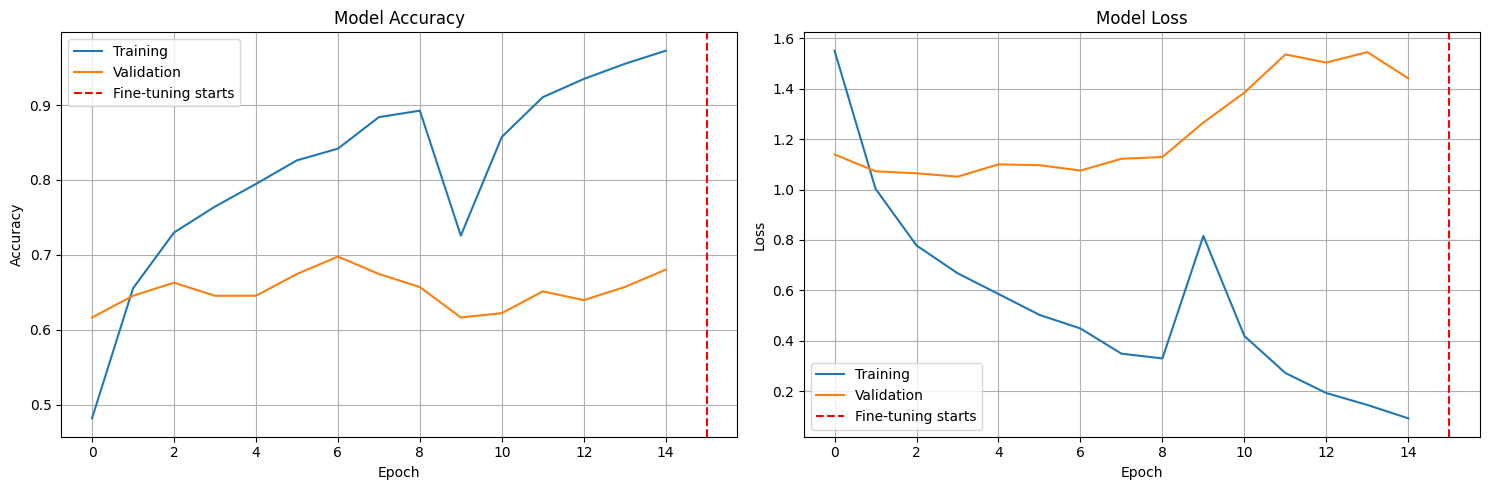

✓ Training history saved

GENERATING FINAL REPORT
✓ Final report saved to: /content/drive/MyDrive/Snake_Project/6_Results/model_training/training_report.json

PHASE 3 COMPLETE - MODEL TRAINING SUMMARY

✓ Model trained successfully!

Performance:
  Accuracy: 55.10%
  Top-3 Accuracy: 78.91%

Saved files:
  Best model: /content/drive/MyDrive/Snake_Project/5_Models/best_model.keras
  Final model: /content/drive/MyDrive/Snake_Project/5_Models/final_model.keras
  Results: /content/drive/MyDrive/Snake_Project/6_Results/model_training

⚠ Accuracy <70%
Consider:
  1. Collecting more training data
  3. Training for more epochs
  4. Adjusting model architecture

Next: Phase 4 - Integration & Testing (prepare species database)



In [5]:
import os
import numpy as np
import matplotlib.pyplot as plt
import json
from datetime import datetime

# TensorFlow imports
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

print("="*80)
print("PHASE 3: CLASSIFICATION MODEL TRAINING")
print("="*80)
print(f"TensorFlow version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")

# ============================================================================
# MOUNT GOOGLE DRIVE
# ============================================================================
from google.colab import drive
drive.mount('/content/drive')

# ============================================================================
# CONFIGURATION
# ============================================================================
PROJECT_ROOT = '/content/drive/MyDrive/Snake_Project'

# Use segmented data if available, otherwise use augmented data
SEGMENTED_PATH = os.path.join(PROJECT_ROOT, '4_Segmented_Dataset')
AUGMENTED_PATH = os.path.join(PROJECT_ROOT, '3_Augmented_Dataset')

if os.path.exists(SEGMENTED_PATH):
    DATA_PATH = SEGMENTED_PATH
    print(f"✓ Using SEGMENTED dataset: {DATA_PATH}")
else:
    DATA_PATH = AUGMENTED_PATH
    print(f"✓ Using AUGMENTED dataset: {DATA_PATH}")

# Output paths
MODEL_PATH = os.path.join(PROJECT_ROOT, '5_Models')
RESULTS_PATH = os.path.join(PROJECT_ROOT, '6_Results', 'model_training')

os.makedirs(MODEL_PATH, exist_ok=True)
os.makedirs(RESULTS_PATH, exist_ok=True)

# Model parameters
IMG_SIZE = (224, 224)  # MobileNetV2 standard input size
BATCH_SIZE = 16  # Smaller batch for limited RAM
EPOCHS = 30  # Can increase if you have time/GPU

print(f"\nConfiguration:")
print(f"  Image size: {IMG_SIZE}")
print(f"  Batch size: {BATCH_SIZE}")
print(f"  Epochs: {EPOCHS}")

# ============================================================================
# DATA LOADING
# ============================================================================
print("\n" + "="*80)
print("LOADING DATASET")
print("="*80)

# --- FIX START: Clean up unexpected directories before loading data ---
# The `DataSet_New` folder was incorrectly picked up as a class.
# This block ensures only actual species folders are processed.
problematic_folder_name = 'DataSet_New'

for split_dir_name in ['train', 'validation', 'test']:
    full_split_path = os.path.join(DATA_PATH, split_dir_name)
    problematic_folder_path = os.path.join(full_split_path, problematic_folder_name)

    if os.path.exists(problematic_folder_path) and os.path.isdir(problematic_folder_path):
        print(f"Removing problematic folder: {problematic_folder_path}")
        try:
            import shutil
            shutil.rmtree(problematic_folder_path)
            print(f"Successfully removed {problematic_folder_name} from {split_dir_name} split.")
        except Exception as e:
            print(f"Error removing {problematic_folder_path}: {e}")
# --- FIX END ---

# Data generators (no augmentation - already done in Phase 1)
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize to [0,1]
    # Augmentation already done, but can add slight variations
    rotation_range=5,
    width_shift_range=0.05,
    height_shift_range=0.05,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Load data
train_generator = train_datagen.flow_from_directory(
    os.path.join(DATA_PATH, 'train'),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

validation_generator = val_datagen.flow_from_directory(
    os.path.join(DATA_PATH, 'validation'),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    os.path.join(DATA_PATH, 'test'),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

NUM_CLASSES = len(train_generator.class_indices)
CLASS_NAMES = list(train_generator.class_indices.keys())

print(f"\n✓ Dataset loaded:")
print(f"  Training samples: {train_generator.samples}")
print(f"  Validation samples: {validation_generator.samples}")
print(f"  Test samples: {test_generator.samples}")
print(f"  Number of classes: {NUM_CLASSES}")
print(f"  Classes: {CLASS_NAMES}")

# Save class mapping
class_mapping = {
    'class_indices': train_generator.class_indices,
    'class_names': CLASS_NAMES
}
with open(os.path.join(RESULTS_PATH, 'class_mapping.json'), 'w') as f:
    json.dump(class_mapping, f, indent=2)

# ============================================================================
# MODEL ARCHITECTURE
# ============================================================================
print("\n" + "="*80)
print("BUILDING MODEL")
print("="*80)

def build_model(num_classes, trainable_base=False):
    """
    Builds MobileNetV2-based classification model

    Args:
        num_classes: Number of snake species
        trainable_base: Whether to train base model layers

    Returns:
        model: Compiled Keras model
    """
    # Load pre-trained MobileNetV2 (without top classification layer)
    base_model = MobileNetV2(
        input_shape=(*IMG_SIZE, 3),
        include_top=False,
        weights='imagenet'
    )

    # Freeze base model initially
    base_model.trainable = trainable_base

    # Build model
    inputs = keras.Input(shape=(*IMG_SIZE, 3))

    # Pre-trained base
    x = base_model(inputs, training=False)

    # Custom classification head
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = keras.Model(inputs, outputs)

    return model

# Build model
model = build_model(NUM_CLASSES, trainable_base=False)

# Compile
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy', keras.metrics.TopKCategoricalAccuracy(k=3, name='top3_accuracy')]
)

model.summary()

print("\n✓ Model built successfully")
print(f"  Total parameters: {model.count_params():,}")
print(f"  Trainable parameters: {sum([tf.keras.backend.count_params(w) for w in model.trainable_weights]):,}")

# ============================================================================
# TRAINING CALLBACKS
# ============================================================================
print("\n" + "="*80)
print("SETTING UP TRAINING")
print("="*80)

callbacks = [
    # Save best model
    ModelCheckpoint(
        filepath=os.path.join(MODEL_PATH, 'best_model.keras'), # Changed from .h5 to .keras
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    ),

    # Early stopping
    EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),

    # Reduce learning rate when stuck
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-7,
        verbose=1
    )
]

print("✓ Callbacks configured:")
print("  - Model checkpointing")
print("  - Early stopping (patience=5)")
print("  - Learning rate reduction")

# ============================================================================
# STAGE 1: TRAIN TOP LAYERS ONLY
# ============================================================================
print("\n" + "="*80)
print("STAGE 1: TRAINING TOP LAYERS (Base frozen)")
print("="*80)

history_stage1 = model.fit(
    train_generator,
    epochs=15,  # Train top layers for 15 epochs
    validation_data=validation_generator,
    callbacks=callbacks,
    verbose=1
)

# Save stage 1 model
model.save(os.path.join(MODEL_PATH, 'model_stage1.keras')) # Changed from .h5 to .keras
print("\n✓ Stage 1 complete - Model saved")

# ============================================================================
# STAGE 2: FINE-TUNING (Unfreeze some base layers)
# ============================================================================
print("\n" + "="*80)
print("STAGE 2: FINE-TUNING (Unfreezing top layers of base model)")
print("="*80)

# Unfreeze the top layers of the base model
base_model = model.layers[1]
base_model.trainable = True

# Freeze all layers except the last 30
for layer in base_model.layers[:-30]:
    layer.trainable = False

# Recompile with lower learning rate
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),  # Lower LR for fine-tuning
    loss='categorical_crossentropy',
    metrics=['accuracy', keras.metrics.TopKCategoricalAccuracy(k=3, name='top3_accuracy')]
)

print(f"Fine-tuning with {sum([tf.keras.backend.count_params(w) for w in model.trainable_weights]):,} trainable parameters")

history_stage2 = model.fit(
    train_generator,
    epochs=EPOCHS - 15,  # Continue for remaining epochs
    validation_data=validation_generator,
    callbacks=callbacks,
    verbose=1
)

# Save final model
model.save(os.path.join(MODEL_PATH, 'final_model.keras')) # Changed from .h5 to .keras
print("\n✓ Stage 2 complete - Final model saved")

# ============================================================================
# EVALUATION
# ============================================================================
print("\n" + "="*80)
print("EVALUATING MODEL ON TEST SET")
print("="*80)

# Load best model
best_model = keras.models.load_model(os.path.join(MODEL_PATH, 'best_model.keras')) # Changed from .h5 to .keras

# Evaluate
test_loss, test_accuracy, test_top3 = best_model.evaluate(test_generator)

print(f"\nTest Results:")
print(f"  Loss: {test_loss:.4f}")
print(f"  Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"  Top-3 Accuracy: {test_top3:.4f} ({test_top3*100:.2f}%)")

# Generate predictions
print("\nGenerating predictions...")
test_generator.reset()
predictions = best_model.predict(test_generator, verbose=1)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes

# Classification report
print("\n" + "="*80)
print("CLASSIFICATION REPORT")
print("="*80)
report = classification_report(
    true_classes,
    predicted_classes,
    target_names=CLASS_NAMES,
    output_dict=True
)

print(classification_report(true_classes, predicted_classes, target_names=CLASS_NAMES))

# Confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig(os.path.join(RESULTS_PATH, 'confusion_matrix.png'), dpi=150)
plt.show()

print(f"\n✓ Confusion matrix saved")

# ============================================================================
# TRAINING HISTORY VISUALIZATION
# ============================================================================
print("\n" + "="*80)
print("VISUALIZING TRAINING HISTORY")
print("="*80)

# Combine both stages
history_combined = {
    'accuracy': history_stage1.history['accuracy'] + history_stage2.history['accuracy'],
    'val_accuracy': history_stage1.history['val_accuracy'] + history_stage2.history['val_accuracy'],
    'loss': history_stage1.history['loss'] + history_stage2.history['loss'],
    'val_loss': history_stage1.history['val_loss'] + history_stage2.history['val_loss']
}

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Accuracy
ax1.plot(history_combined['accuracy'], label='Training')
ax1.plot(history_combined['val_accuracy'], label='Validation')
ax1.axvline(x=15, color='r', linestyle='--', label='Fine-tuning starts')
ax1.set_title('Model Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid(True)

# Loss
ax2.plot(history_combined['loss'], label='Training')
ax2.plot(history_combined['val_loss'], label='Validation')
ax2.axvline(x=15, color='r', linestyle='--', label='Fine-tuning starts')
ax2.set_title('Model Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.savefig(os.path.join(RESULTS_PATH, 'training_history.png'), dpi=150)
plt.show()

print(f"✓ Training history saved")

# ============================================================================
# SAVE FINAL REPORT
# ============================================================================
print("\n" + "="*80)
print("GENERATING FINAL REPORT")
print("="*80)

final_report = {
    'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'model_architecture': 'MobileNetV2',
    'dataset': {
        'train_samples': train_generator.samples,
        'val_samples': validation_generator.samples,
        'test_samples': test_generator.samples,
        'num_classes': NUM_CLASSES,
        'class_names': CLASS_NAMES
    },
    'training': {
        'epochs': EPOCHS,
        'batch_size': BATCH_SIZE,
        'image_size': IMG_SIZE
    },
    'results': {
        'test_loss': float(test_loss),
        'test_accuracy': float(test_accuracy),
        'test_top3_accuracy': float(test_top3)
    },
    'classification_report': report
}

report_path = os.path.join(RESULTS_PATH, 'training_report.json')
with open(report_path, 'w') as f:
    json.dump(final_report, f, indent=2)

print(f"✓ Final report saved to: {report_path}")

# ============================================================================
# SUMMARY
# ============================================================================
print("\n" + "="*80)
print("PHASE 3 COMPLETE - MODEL TRAINING SUMMARY")
print("="*80)
print(f"\n✓ Model trained successfully!")
print(f"\nPerformance:")
print(f"  Accuracy: {test_accuracy*100:.2f}%")
print(f"  Top-3 Accuracy: {test_top3*100:.2f}%")
print(f"\nSaved files:")
print(f"  Best model: {os.path.join(MODEL_PATH, 'best_model.keras')}") # Changed from .h5 to .keras
print(f"  Final model: {os.path.join(MODEL_PATH, 'final_model.keras')}") # Changed from .h5 to .keras
print(f"  Results: {RESULTS_PATH}")

if test_accuracy >= 0.80:
    print(f"\n✓✓✓ EXCELLENT! Accuracy \u226580%")
    print("Your model is ready for deployment!")
elif test_accuracy >= 0.70:
    print(f"\n✓✓ GOOD! Accuracy \u226570%")
    print("Model is working well. Consider collecting more data for improvement.")
else:
    print(f"\n\u26a0 Accuracy <70%")
    print("Consider:")
    print("  1. Collecting more training data")
    ("  2. Improving data quality")
    print("  3. Training for more epochs")
    print("  4. Adjusting model architecture")

print("\n" + "="*80)
print("Next: Phase 4 - Integration & Testing (prepare species database)")
print("="*80 + "\n")

Loading model from: /content/drive/MyDrive/Snake_Project/5_Models/best_model.h5...


✓ Model loaded successfully.
✓ Loaded 12 class labels.

UPLOAD IMAGE FOR TESTING
Please upload an image file using the button below:


Saving python.jfif to python.jfif

Analyzing python.jfif...
Model expects input shape: (224, 224)


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
------------------------------
Result for python.jfif
Predicted Species: Common Rat Snake
Confidence:        41.74%


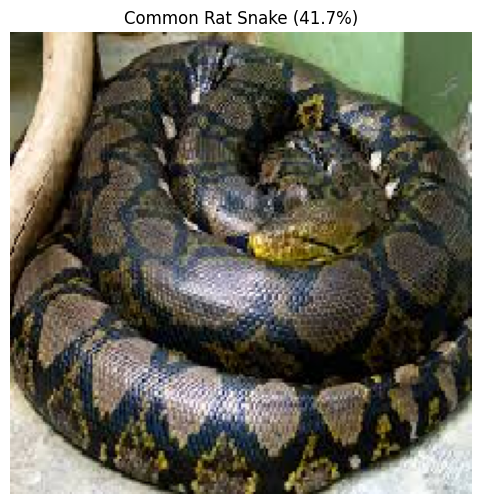

In [8]:
import os
import json
import numpy as np
import tensorflow as pd
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

# ==========================================
# CONFIGURATION
# ==========================================
# Paths based on your notebook structure
PROJECT_ROOT = '/content/drive/MyDrive/Snake_Project'
MODEL_PATH = os.path.join(PROJECT_ROOT, '5_Models/best_model.h5')
RESULTS_DIR = os.path.join(PROJECT_ROOT, '6_Results/model_training')

# Try to find class indices (mapping of ID to Snake Name)
# Usually saved as class_mapping.json during training
CLASS_MAPPING_PATH = os.path.join(RESULTS_DIR, 'class_mapping.json')

def load_snake_model(model_path):
    """Loads the trained Keras model."""
    if not os.path.exists(model_path):
        raise FileNotFoundError(f"Model not found at {model_path}")

    print(f"Loading model from: {model_path}...")
    model = pd.keras.models.load_model(model_path)
    print("✓ Model loaded successfully.")
    return model

def load_class_labels(json_path):
    """Loads class labels from JSON if available."""
    if os.path.exists(json_path):
        with open(json_path, 'r') as f:
            data = json.load(f)

        # Expecting a dictionary with 'class_indices' and 'class_names'
        class_indices = data.get('class_indices')
        if class_indices:
            # Swap keys and values to get {index: 'Snake Name'}
            labels = {v: k for k, v in class_indices.items()}
            print(f"✓ Loaded {len(labels)} class labels.")
            return labels
        else:
            print(f"⚠ 'class_indices' key not found in {json_path}.")
            print("  Predictions will return numeric class IDs instead of names.")
            return None
    else:
        print(f"⚠ Class mapping file not found at {json_path}.")
        print("  Predictions will return numeric class IDs instead of names.")
        return None

def preprocess_image(img_path, target_size):
    """
    Loads and preprocesses an image for the model.
    Scaling is set to 1./255 based on standard practices.
    """
    if not os.path.exists(img_path):
        raise FileNotFoundError(f"Image not found at {img_path}")

    # Load image with target size matching the model
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)

    # Add batch dimension (e.g., from (224, 224, 3) to (1, 224, 224, 3))
    img_batch = np.expand_dims(img_array, axis=0)

    # Normalize pixel values (0-255 -> 0-1)
    # NOTE: If you used specific preprocessing (like VGG16/ResNet specific), change this line.
    img_preprocessed = img_batch / 255.0

    return img, img_preprocessed

def predict_snake(model, img_path, class_labels=None):
    """Runs prediction on a single image."""

    # 1. Get expected input shape from model (height, width)
    # model.input_shape is typically (None, height, width, channels)
    input_shape = model.input_shape[1:3]
    print(f"Model expects input shape: {input_shape}")

    # 2. Preprocess
    original_img, processed_img = preprocess_image(img_path, input_shape)

    # 3. Predict
    predictions = model.predict(processed_img)
    confidence_score = np.max(predictions)
    predicted_class_index = np.argmax(predictions)

    # 4. Decode Result
    if class_labels:
        result_label = class_labels.get(predicted_class_index, "Unknown Class")
    else:
        result_label = f"Class ID {predicted_class_index}"

    return result_label, confidence_score, original_img

# ==========================================
# MAIN EXECUTION
# ==========================================
if __name__ == "__main__":
    try:
        # Load resources
        model = load_snake_model(MODEL_PATH)
        labels = load_class_labels(CLASS_MAPPING_PATH)

        print("\n" + "="*50)
        print("UPLOAD IMAGE FOR TESTING")
        print("="*50)

        # Check if running in Colab to use the file uploader
        try:
            from google.colab import files
            print("Please upload an image file using the button below:")
            uploaded = files.upload()

            if not uploaded:
                print("No file selected.")

            for filename in uploaded.keys():
                print(f"\nAnalyzing {filename}...")

                # Make prediction
                label, confidence, img = predict_snake(model, filename, labels)

                # Display Results
                print("-" * 30)
                print(f"Result for {filename}")
                print(f"Predicted Species: {label}")
                print(f"Confidence:        {confidence:.2%}")

                # Show image
                plt.figure(figsize=(6, 6))
                plt.imshow(img)
                plt.title(f"{label} ({confidence:.1%})")
                plt.axis('off')
                plt.show()

        except ImportError:
            # Fallback for local execution (not in Colab)
            print("Google Colab environment not detected.")
            test_image_path = input("Please enter the full path to your test image: ").strip()

            if test_image_path and os.path.exists(test_image_path):
                # Make prediction
                label, confidence, img = predict_snake(model, test_image_path, labels)

                # Display Results
                print("\n" + "="*50)
                print("PREDICTION RESULTS")
                print("="*50)
                print(f"Predicted Species: {label}")
                print(f"Confidence:        {confidence:.2%}")

                plt.figure(figsize=(6, 6))
                plt.imshow(img)
                plt.title(f"{label} ({confidence:.1%})")
                plt.axis('off')
                plt.show()
            else:
                print("Invalid path provided or file does not exist.")

    except Exception as e:
        print(f"\n❌ Error: {e}")